# Considerations for PAAM step size and operations

The purpose of this notebook is to produce additional information regarding the operational concept of the PAAM w.r.t speed, step size and update rate.

In [2]:
from matplotlib import pyplot as plt 
import numpy as np
import math

%matplotlib widget  

plt.style.use('dark_background')

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

## Definition of required orbital profile and other quantities

In [4]:
period = 365*24*60*60 # orbital period in seconds
paa_amplitude = 2.8e-6 # paa amplitude in rad
def paa(t): 
    return np.sin(t/period*2*math.pi)*paa_amplitude
inertial_to_paam = 134 #conversion factor for angles from inertial to paam frame
seconds_per_hour = 60*60

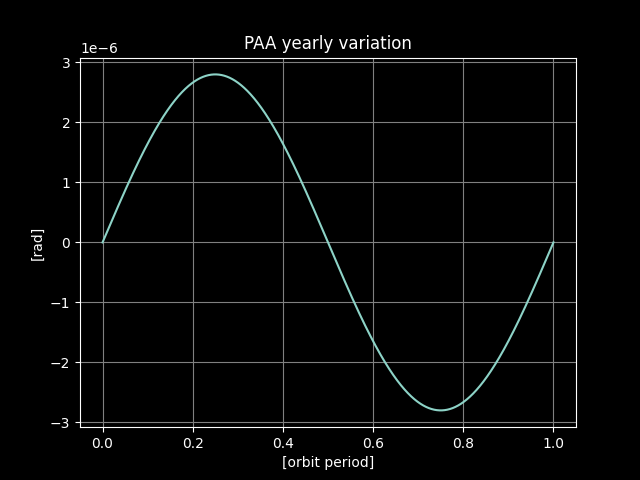

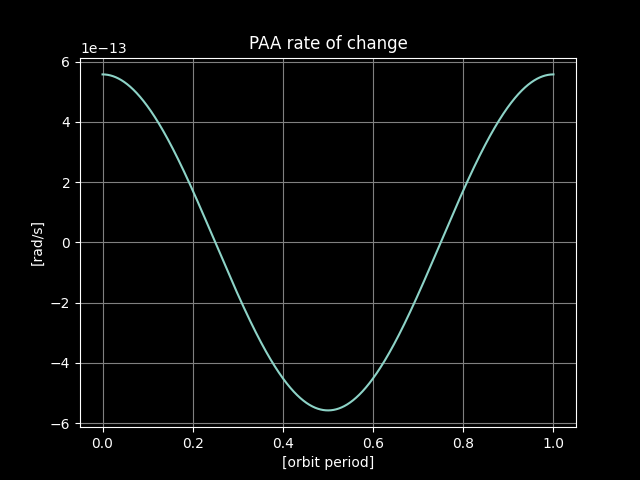

In [5]:
plot_step = 100 #s
t_range = np.arange(0,period,step=plot_step)
plt.figure()
plt.title("PAA yearly variation")
plt.ylabel("[rad]")
plt.xlabel("[orbit period]")
plt.plot(t_range/period, [paa(t) for t in t_range])
plt.grid('both', color="grey")
plt.show()
plt.figure()
plt.title("PAA rate of change")
plt.ylabel("[rad/s]")
plt.xlabel("[orbit period]")
plt.plot(t_range[:-1]/period, np.diff([paa(t) for t in t_range])/plot_step)
plt.grid('both', color="grey")
plt.show()

## Modelling different operation scenarios
### step-stare with constant step-size

In [6]:
def const_step_profile(step_size = 15e-9, resolution=1): 

    step_times = np.arange(0,period,resolution)
    step_position = paa(step_times)
    print("Done with high res trajectory")

    current_pos = 0.0
    step_time = 0.0
    has_stepped = False

    event_time = [step_time]
    event_position = [current_pos]

    for step_time, nominal_pos in zip(step_times, step_position):

        if nominal_pos-current_pos >= step_size:
            # make a step

            current_pos += step_size
            has_stepped = True

        elif nominal_pos-current_pos <= -step_size:

            current_pos -= step_size
            has_stepped = True
        
        else:
            
            has_stepped = False

        if has_stepped:

            #print(f"events {len(event_time)}")

            event_time.append(step_time)
            event_position.append(current_pos)
    
    return (event_time, event_position)

In [7]:
event_time, event_position = const_step_profile(step_size = 15e-9)

Done with high res trajectory


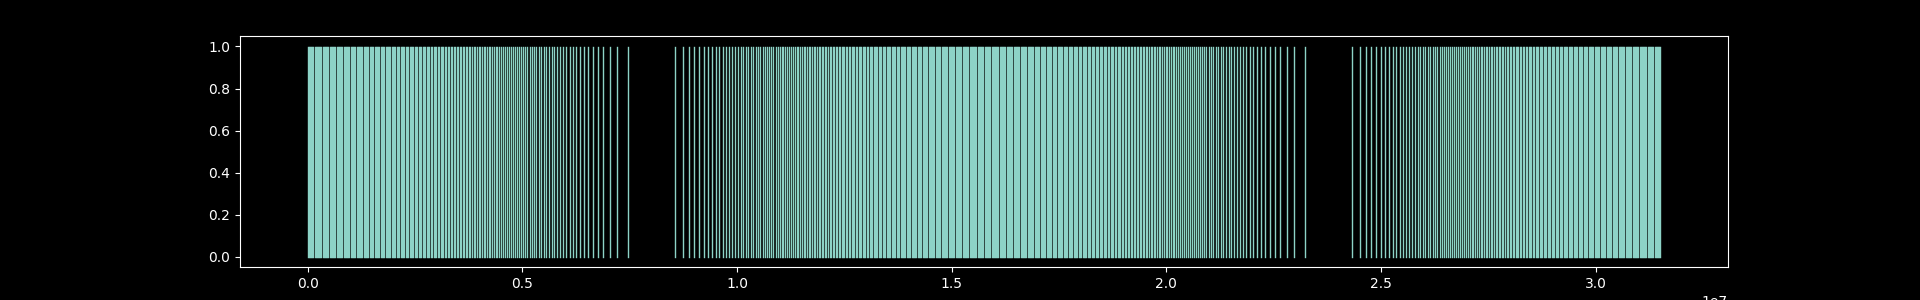

In [8]:
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(1920*px,300*px))
for event in event_time:
    plt.plot([event,event],[0,1], color='C0', linewidth=1)
plt.show()

Done with high res trajectory
Stepsize = 1e-08
maximum time between steps: 117.86638888888889 [hrs] ~ 
minimum time between steps: 4.979166666666667 [hrs]
highest frequency: 0.05578800557880056 [mHz]
Done with high res trajectory
Stepsize = 1.5e-08
maximum time between steps: 304.3125 [hrs] ~ 
minimum time between steps: 7.4688888888888885 [hrs]
highest frequency: 0.037191312109491226 [mHz]
Done with high res trajectory
Stepsize = 2e-08
maximum time between steps: 166.73805555555555 [hrs] ~ 
minimum time between steps: 9.95861111111111 [hrs]
highest frequency: 0.027893224735711694 [mHz]
Done with high res trajectory
Stepsize = 3e-08
maximum time between steps: 353.81 [hrs] ~ 
minimum time between steps: 14.938055555555556 [hrs]
highest frequency: 0.018595310262751734 [mHz]
Done with high res trajectory
Stepsize = 4e-08
maximum time between steps: 570.0194444444444 [hrs] ~ 
minimum time between steps: 19.91777777777778 [hrs]
highest frequency: 0.013946223362713377 [mHz]
Done with high r

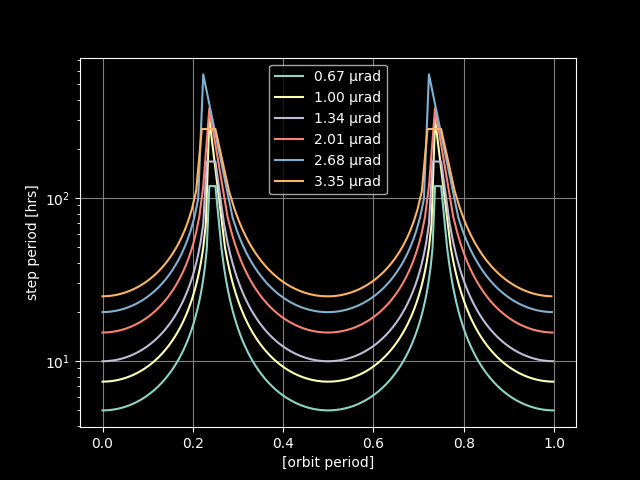

In [16]:
plt.figure()
for step_size in [10e-9,15e-9, 20e-9, 30e-9, 40e-9, 50e-9]:
        event_time, event_position = const_step_profile(step_size=step_size, resolution =1)
        plt.semilogy(np.array(event_time[:-1])/period,np.diff(event_time)/3600, label=f"{step_size*134/2*1e6:.2f} µrad")
        plt.grid('both', color="grey")
        plt.xlabel("[orbit period]")
        plt.ylabel("step period [hrs]")
        plt.legend()
        
        print(f"Stepsize = {step_size}")
        print(f"maximum time between steps: {max(abs(np.diff(event_time)))/3600} [hrs] ~ ")
        print(f"minimum time between steps: {min(abs(np.diff(event_time)))/3600} [hrs]")
        print(f"highest frequency: {1/min(abs(np.diff(event_time)))*1000} [mHz]")

plt.show()

In [10]:
15e-9 *134/2

1.005e-06

## "Continous" operation with minimal step size
in this case it is of special interest when the effective motion (step size limited) becomes in band

we have defined the nominal trajectory of the Point Ahead Angle earlier as 

$$ \Omega = sin(t/P*2*\pi)*2.8\mu rad $$

where $P$ is the orbital period in seconds (31.5e6)

The rate of change of the PAA is thus given as 

$$ \frac{\partial \Omega}{\partial t} = 2.8 \frac{2\pi}{P} cos(t/P*2*\pi) [µrad/s]$$


In [11]:
print(2.8*2*math.pi/period)
print(2*math.pi/period)

5.578677974411099e-07
1.9923849908611068e-07



For the given yearly period of the LISA orbit this simplifies to

$$  \frac{\partial \Omega}{\partial t} = 5.6\mathrm{e}{-7} \cdot cos(t \cdot 2\mathrm{e}{-7}) [µrad/s] $$



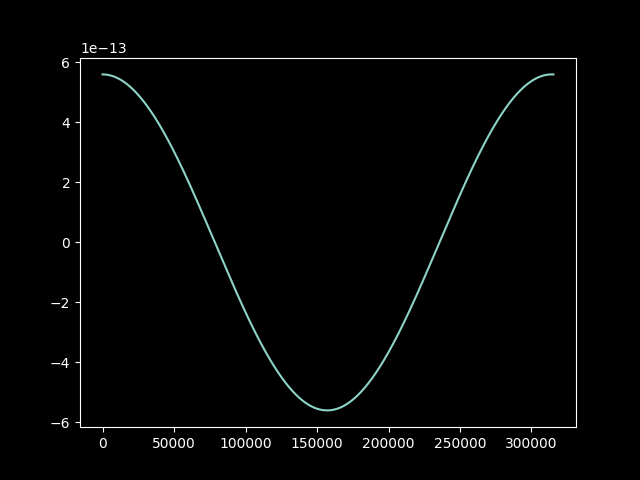

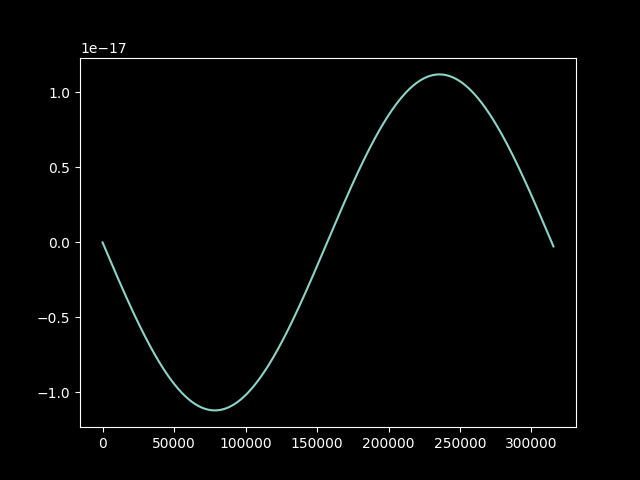

In [12]:
plt.figure()
plt.plot([5.6e-7*np.cos(t*2e-7)*1e-6 for t in np.arange(0,period,100)])
plt.show()
plt.figure()
plt.plot(np.diff([5.6e-7*np.cos(t*2e-7)*1e-6 for t in np.arange(0,period,100)]))
plt.show()

In [13]:
5.67e-7*134/2*1e6

37.989000000000004

From the previous formula and given the fact that $\cos{X}$ can only be within [-1,1] we can already reason that the maximum step size and speed in this mode would be

$$ v_{max} = 5.6e-7 *134 /2 =  38 prad/s $$

And in turn a step size at that poitn of 

$$ s_{max} = 3.8 prad $$

if we consider a nominal update rate of 10 Hz to ensure the continous stepping to be sufficiently out of band.

It is clear that this is well outside the capabilities of the PAAM and thus, true outside the band fast stepping (continous) is not possible.
Only by means of an analog filter (effect) in the FEE after the primary quantization might mitigate this to some tbd amount. 

lets explore further how noise related to coarser paam motion

In [14]:
# generate a series of motion profiles that try to perform "continous§ motion " with n